This dataset contains 64300 reviews with 5 attributes, Name of apps, User review, Sentiment label, Sentiment polarity and Sentiment subject. For this task the target texts are users’ reviews and class labels are sentiment labels. Thus, this is a supervised learning task.

The main process of Text classification has some important stages like prepro- cessing, tokenize, word to vector, feature selection, build classifiers and evaluate models.

In [1]:
import csv
import pandas as pd
import numpy as np
import re

## Preprocessing raw data

In [2]:
# read original data
datalist = []
with open('googleplaystore_user_reviews.csv') as f:
    reader = csv.reader(f)
    headers = next(reader)
    for row in reader:
        datalist.append(row)
# select text strings and labels
dataframe = pd.DataFrame(np.array(datalist))
df1 = (np.array(dataframe[[1,2]]))

In [6]:
# remove the missing values 'nan'
count = 0
review = []
for s,v in df1:
    if s != "nan":
        review.append([s,v])
print("The size of corpus is :"+str(len(review)))

The size of corpus is :37432


In [7]:
# clean the corpus with regular expression
r1 = "[\s+\.\!\-\?\/_,$%^*(+\"]+|[+——！:，。？、~@#￥%……&*（）]+"
r2 = '(\s\'+\s)|(\'(\s|$))|\)'
cleantxt = []
corpus = []
label = []
for word,tag in review:
    result = re.sub(r1,' ',word)
    result = re.sub(r2,' ',result)
    result = re.sub('\d+',' ',result)
    result = re.sub('\s+',' ',result)
    cleantxt.append([result.lower(),tag])
    corpus.append(result.lower())
    label.append(tag)

In [9]:
# build the corpus and write to txt file
with open("clean.txt",'w',encoding='utf-8') as wf:
    for row in cleantxt:
        wf.write(row[0]+","+row[1]+"\n")

In [10]:
import csv
import itertools
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from mlxtend.evaluate import paired_ttest_kfold_cv
from scipy.stats import friedmanchisquare
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_validate
from sklearn.model_selection import learning_curve
from sklearn.model_selection import train_test_split
from sklearn.model_selection import validation_curve
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils.multiclass import unique_labels

In [11]:
# load the stopword list
english_stp = []
with open('StopWords.txt', 'r') as stf:
    for line in stf.readlines():
        english_stp.append(line.strip('\n'))

## Overview the dataset 

In [12]:
print('Original dataset shape %s' % Counter(label))

Original dataset shape Counter({'Positive': 23998, 'Negative': 8271, 'Neutral': 5163})


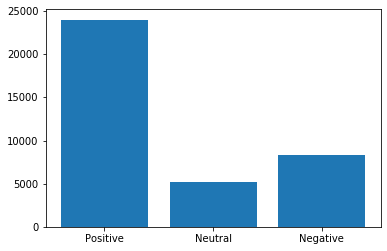

In [17]:
plt.bar(Counter(label).keys(),Counter(label).values())
plt.show()

In [20]:
# vectorize and tokenize the corpus
vectorizer = TfidfVectorizer(analyzer='word', max_features=10000, ngram_range=(1, 2), stop_words=english_stp)
X = vectorizer.fit_transform(corpus)

word_reduced = SelectKBest(chi2, k=1000).fit_transform(X, label)

# handling of class imbalance
X, y = word_reduced, label

This data labels are not balanced. First, we need to balance the data

In [26]:
rus = RandomUnderSampler(sampling_strategy="majority", random_state=42)
X_under, y_under = rus.fit_resample(X, y)
print('Undersampled dataset shape %s' % Counter(y_under))

Undersampled dataset shape Counter({'Negative': 8271, 'Neutral': 5163, 'Positive': 5163})


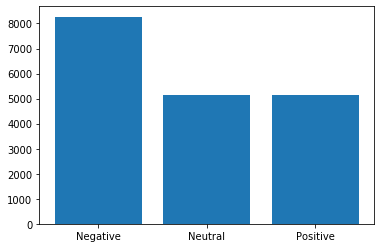

In [28]:
plt.bar(Counter(y_under).keys(),Counter(y_under).values())
plt.show()

## Define some util functions

In [29]:
# the function of plotting classification report
def plot_classification_report(clf, X, y):
    class_names = unique_labels(y)
    error_evaluation = cross_val_predict(estimator=clf, X=X, y=y, cv=10)
    print(classification_report(y, error_evaluation, target_names=class_names))

In [30]:
# the function of plotting learning curve
def plot_learning_curve(clf, X, y, clf_name):
    train_sizes, train_scores, valid_scores = learning_curve(clf, X, y,
                                                             train_sizes=[50, 100, 150, 200, 250, 300, 350, 400, 500,
                                                                          600], cv=10)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(valid_scores, axis=1)
    test_scores_std = np.std(valid_scores, axis=1)
    plt.grid()
    plt.title("Learning curve for " + clf_name)
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")
    plt.xlabel("Sample Size")
    plt.ylabel("Accuracy")
    plt.legend(loc="best")
    plt.show()

In [31]:
# the function of calculating paired p value
def paired_ttest(X, y, clf1, clf2):
    t, p = paired_ttest_kfold_cv(estimator1=clf1, estimator2=clf2, X=X, y=np.array(y))
    print('t statistic: %.3f' % t)
    print('p value: %.3f' % p)

In [33]:
# the function of plotting confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.get_cmap("Blues")):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    # print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Build some Machine Learning Models

In [34]:
# build classifiers
seed = 2021
svm_clf = LinearSVC(random_state=seed, tol=1e-5)
nb_clf = MultinomialNB()
dt_clf = DecisionTreeClassifier(criterion='entropy', max_features='sqrt', random_state=seed)
knn_clf = KNeighborsClassifier(n_neighbors=7, n_jobs=2)
rfc_clf = RandomForestClassifier(random_state=seed)

In [35]:
# Rename the data and label
X = X_under
y = y_under

In [36]:
###error evaluation curves
print("Classification report for KNN")
plot_classification_report(knn_clf, X, y)


Classification report for KNN
              precision    recall  f1-score   support

    Negative       0.80      0.60      0.68      8271
     Neutral       0.49      0.80      0.61      5163
    Positive       0.61      0.47      0.53      5163

    accuracy                           0.62     18597
   macro avg       0.63      0.62      0.61     18597
weighted avg       0.66      0.62      0.62     18597



In [37]:
print("Classification report for SVM")
plot_classification_report(svm_clf, X, y)


Classification report for SVM
              precision    recall  f1-score   support

    Negative       0.87      0.84      0.86      8271
     Neutral       0.69      0.90      0.78      5163
    Positive       0.81      0.61      0.69      5163

    accuracy                           0.79     18597
   macro avg       0.79      0.78      0.78     18597
weighted avg       0.80      0.79      0.79     18597



In [38]:
print("Classification report for DT")
plot_classification_report(dt_clf, X, y)


Classification report for DT
              precision    recall  f1-score   support

    Negative       0.79      0.71      0.75      8271
     Neutral       0.67      0.77      0.72      5163
    Positive       0.58      0.59      0.59      5163

    accuracy                           0.69     18597
   macro avg       0.68      0.69      0.69     18597
weighted avg       0.70      0.69      0.70     18597



In [39]:
print("Classification report for RFC")
plot_classification_report(rfc_clf, X, y)


Classification report for RFC
              precision    recall  f1-score   support

    Negative       0.84      0.82      0.83      8271
     Neutral       0.71      0.82      0.76      5163
    Positive       0.70      0.62      0.66      5163

    accuracy                           0.76     18597
   macro avg       0.75      0.75      0.75     18597
weighted avg       0.76      0.76      0.76     18597



In [40]:
print("Classification report for NB")
plot_classification_report(nb_clf, X.todense(), y)

Classification report for NB
              precision    recall  f1-score   support

    Negative       0.56      0.93      0.70      8271
     Neutral       0.71      0.31      0.43      5163
    Positive       0.85      0.44      0.58      5163

    accuracy                           0.62     18597
   macro avg       0.71      0.56      0.57     18597
weighted avg       0.68      0.62      0.59     18597



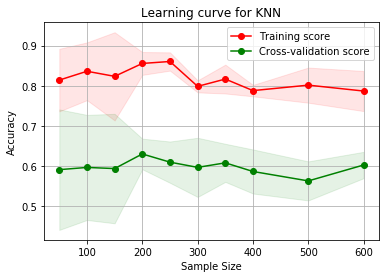

In [41]:
plot_learning_curve(knn_clf, word_reduced, label, "KNN")


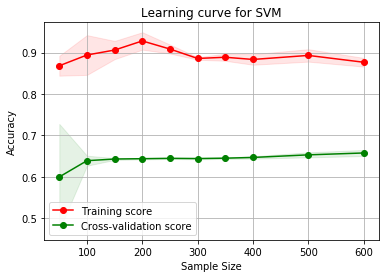

In [42]:
plot_learning_curve(svm_clf, word_reduced, label, "SVM")


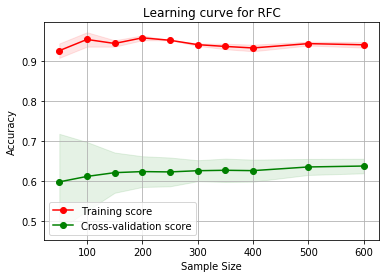

In [43]:
plot_learning_curve(rfc_clf, word_reduced, label, "RFC")


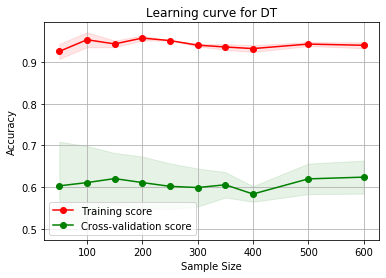

In [44]:
plot_learning_curve(dt_clf, word_reduced, label, "DT")


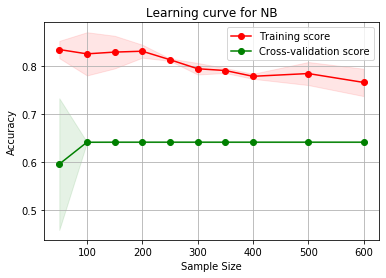

In [45]:
plot_learning_curve(nb_clf, word_reduced.todense(), label, "NB")

## Paired T-test for each pair of classifiers

In [46]:
# paired t test for each pair, 10 pairs in total
print("t test for classfiers KNN and DT")
paired_ttest(X, y, knn_clf, dt_clf)
print("t test for classfiers KNN and SVM")
paired_ttest(X, y, knn_clf, svm_clf)
print("t test for classfiers KNN and RFC")
paired_ttest(X, y, knn_clf, rfc_clf)
print("t test for classfiers KNN and NB")
paired_ttest(X.todense(), y, knn_clf, nb_clf)
print("t test for classfiers DT and SVM")
paired_ttest(X, y, dt_clf, svm_clf)
print("t test for classfiers DT and RFC")
paired_ttest(X, y, dt_clf, rfc_clf)
print("t test for classfiers DT and NB")
paired_ttest(X.todense(), y, dt_clf, nb_clf)
print("t test for classfiers SVM and RFC")
paired_ttest(X, y, svm_clf, rfc_clf)
print("t test for classfiers SVM and NB")
paired_ttest(X.todense(), y, svm_clf, nb_clf)
print("t test for classfiers RFC and NB")
paired_ttest(X.todense(), y, rfc_clf, nb_clf)

t test for classfiers KNN and DT
t statistic: -3.998
p value: 0.003
t test for classfiers KNN and SVM
t statistic: -6.751
p value: 0.000
t test for classfiers KNN and RFC
t statistic: -5.154
p value: 0.001
t test for classfiers KNN and NB
t statistic: 0.317
p value: 0.758
t test for classfiers DT and SVM
t statistic: -4.484
p value: 0.002
t test for classfiers DT and RFC
t statistic: -3.439
p value: 0.007
t test for classfiers DT and NB
t statistic: 1.389
p value: 0.198
t test for classfiers SVM and RFC
t statistic: 3.851
p value: 0.004
t test for classfiers SVM and NB
t statistic: 2.698
p value: 0.024
t test for classfiers RFC and NB
t statistic: 2.383
p value: 0.041


## Plot Confusion Matrix for each classifier

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

y_pred_svm = svm_clf.fit(X_train, y_train).predict(X_test)
cm_svm = confusion_matrix(y_test, y_pred_svm)

y_pred_knn = knn_clf.fit(X_train, y_train).predict(X_test)
cm_knn = confusion_matrix(y_test, y_pred_knn)

y_pred_rfc = rfc_clf.fit(X_train, y_train).predict(X_test)
cm_rfc = confusion_matrix(y_test, y_pred_rfc)

y_pred_dt = dt_clf.fit(X_train, y_train).predict(X_test)
cm_dt = confusion_matrix(y_test, y_pred_dt)

y_pred_dt = nb_clf.fit(X_train, y_train).predict(X_test)
cm_nb = confusion_matrix(y_test, y_pred_dt)

In [49]:
class_names = unique_labels(y)

Confusion matrices - SVM
Confusion matrix, without normalization
Normalized confusion matrix


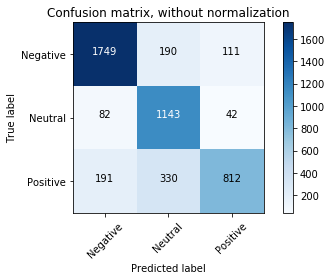

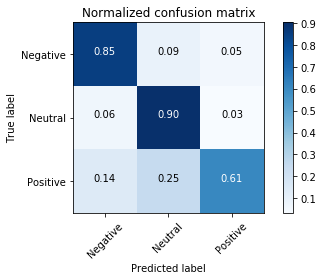

In [50]:
# for SVM
print("Confusion matrices - SVM")
plt.figure()
plot_confusion_matrix(cm_svm, classes=class_names, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cm_svm, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Confusion matrices - KNN
Confusion matrix, without normalization
Normalized confusion matrix


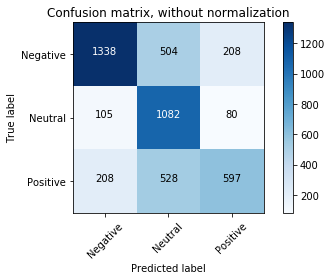

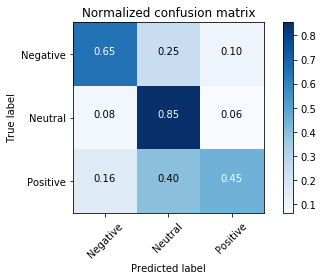

In [51]:
# for KNN
print("Confusion matrices - KNN")
plt.figure()
plot_confusion_matrix(cm_knn, classes=class_names, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cm_knn, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Confusion matrices - RFC
Confusion matrix, without normalization
Normalized confusion matrix


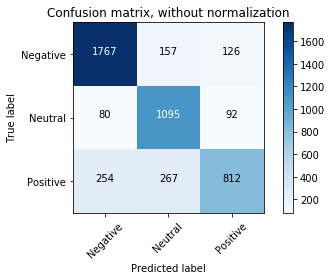

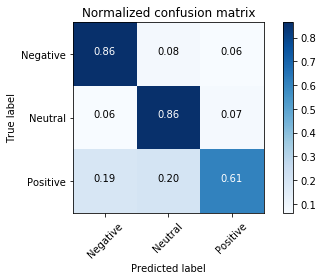

In [52]:
# for RFC
print("Confusion matrices - RFC")
plt.figure()
plot_confusion_matrix(cm_rfc, classes=class_names, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cm_rfc, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Confusion matrices - DT
Confusion matrix, without normalization
Normalized confusion matrix


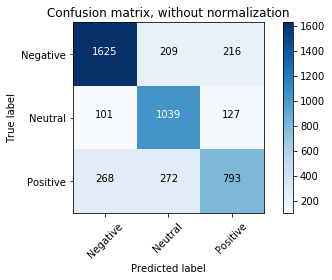

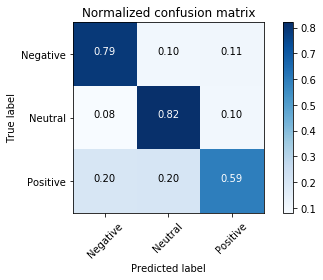

In [53]:
# for DT
print("Confusion matrices - DT")
plt.figure()
plot_confusion_matrix(cm_dt, classes=class_names, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cm_dt, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

Confusion matrices - NB
Confusion matrix, without normalization
Normalized confusion matrix


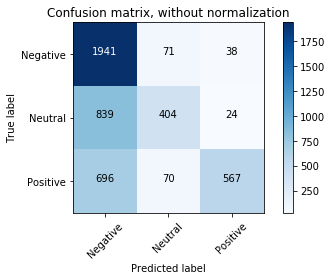

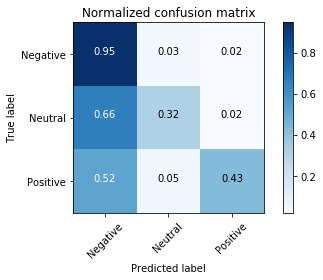

In [54]:
# for NB
print("Confusion matrices - NB")
plt.figure()
plot_confusion_matrix(cm_nb, classes=class_names, title='Confusion matrix, without normalization')

plt.figure()
plot_confusion_matrix(cm_nb, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.show()

## Firedman's test

In [56]:
def cv_all(word_reduced, label):
    svm_cv_results = cross_validate(svm_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False)
    nb_cv_results = cross_validate(nb_clf, word_reduced, label,
                                   scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                   return_train_score=False)
    dt_cv_results = cross_validate(dt_clf, word_reduced, label,
                                   scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                   return_train_score=False)
    knn_cv_results = cross_validate(knn_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False)
    rfc_cv_results = cross_validate(rfc_clf, word_reduced, label,
                                    scoring=['accuracy', 'recall_macro', 'precision_macro', 'f1_macro'], cv=10,
                                    return_train_score=False)
    return svm_cv_results, nb_cv_results, dt_cv_results, knn_cv_results, rfc_cv_results

In [57]:
# Firedman's test
# test 5 different features size
feat_num = [50, 100, 250, 500, 1000]
acc_rs = []
all_rs = []
for kv in feat_num:
    feat_redu = SelectKBest(chi2, k=kv).fit_transform(X, y)
    r1, r2, r3, r4, r5 = cv_all(feat_redu, y)
    print(str(kv) + " is over!")
    acc1 = np.mean(r1['test_accuracy'])
    acc2 = np.mean(r2['test_accuracy'])
    acc3 = np.mean(r3['test_accuracy'])
    acc4 = np.mean(r4['test_accuracy'])
    acc5 = np.mean(r5['test_accuracy'])
    acc_rs.append([acc1, acc2, acc3, acc4, acc5])
    all_rs.append([r1, r2, r3, r4, r5])

50 is over!
100 is over!
250 is over!
500 is over!
1000 is over!


In [58]:
data1 = acc_rs[0]
data2 = acc_rs[1]
data3 = acc_rs[2]
data4 = acc_rs[3]
data5 = acc_rs[4]

stat, p = friedmanchisquare(data1, data2, data3, data4, data5)
print('Statistics=%.3f, p=%.3f' % (stat, p))

Statistics=9.120, p=0.058


## ROC and Recall-Precision graph

In [114]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import label_binarize

# For each class
precision = dict()
recall = dict()
average_precision = dict()
n_classes = len(class_names)
y = label_binarize(y_under,classes=['Negative', 'Positive', 'Neutral'])
#X_under, y_under

In [115]:
X_train, X_test, y_train, y_test = train_test_split(X_under,y, test_size=0.333,
                                                    random_state=seed)

In [133]:
from sklearn.multiclass import OneVsRestClassifier
classifier = OneVsRestClassifier(svm_clf)
y_score = classifier.fit(X_train, y_train).decision_function(X_test)

In [134]:
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_score[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_score[:, i])

In [135]:
# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_score.ravel())
average_precision["micro"] = average_precision_score(y_test, y_score,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.86


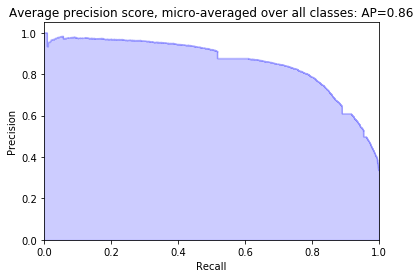

In [136]:
from funcsigs import signature
step_kwargs = ({'step': 'post'}
               if 'step' in signature(plt.fill_between).parameters
               else {})
plt.figure()
plt.step(recall['micro'], precision['micro'], color='b', alpha=0.2,
         where='post')
plt.fill_between(recall["micro"], precision["micro"], alpha=0.2, color='b',
                 **step_kwargs)

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title(
    'Average precision score, micro-averaged over all classes: AP={0:0.2f}'
    .format(average_precision["micro"]))
plt.savefig('average precision score.png')

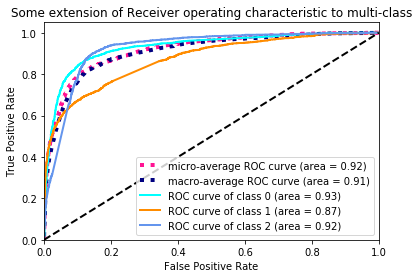

In [137]:
from sklearn.metrics import roc_curve, auc
from scipy import interp
from itertools import cycle

#===========================================ROC curve =====================
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(0,3):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
n_classes = 3
lw=2
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))
# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()